# Model prediction maker

Model setup is as follows: we have dijet asymmetry data prepared, where the asymmetry AJ is defined as the difference between the two jets divided by the sum. Specifically,

$$A_{\mathrm{j}} = \frac{p_{\mathrm{T, 1}} - p_{\mathrm{T, 2}}}{p_{\mathrm{T, 1}} + p_{\mathrm{T, 2}}}$$

We will construct a model to describe the energy loss observed in the dijet asymmetry.  For this model, we consider back-to-back dijets.  Each jet can lose energy, and the lost energy is parameterized as

$$ \Delta p_{\mathrm{T}} / p_{\mathrm{T}} \sim A \times Gaus(1, B)$$

In addition to the energy loss contribution, we have extra "apparent" smearing on the AJ coming from the fact that we have other processes going on in the events (three jets etc).  It is parameterized as a Gaussian smearing on AJ with width C. So there are three total parameters: A, B, and C.

The measurement is done in two bins of centrality.  One in central event, where (A, B, C) are all relevant, and another one in very peripheral event, where only the parameter (C) is relevant.

The goal here in this notebook is to make the inputs needed for Bayesian inference to learn about A, B and C from the provided data

In [1]:
from pathlib import Path

import numpy as np

folder = Path('input/XJGammaToy/')
folder.mkdir(parents=True, exist_ok=True)

In [276]:
# xj or Aj
#DataXMin        = 0.000
#DataXMax        = 1.000
#DataXBin        = 0.050
# xj gamma
DataXMin        = 0.000
DataXMax        = 2.000
DataXBin        = 0.125

DataNBin        = int((DataXMax - DataXMin) / DataXBin)

# how many design points do you want to generate?
NDesign         = 100

# What is the upper parameter range (one each for A, B, C)?
# The lower range for each parameter is 0 by construction.
# Hint: start with a large-range guess!  Then we can come back and reduce range
#ParameterRanges = [(0, 1.0), (0.0, 1.0), (-0.5, 1.5), (0.1, 1.0)]
ParameterRanges = [(0, 1.0), (0.0, 1.0), (0, 1.5), (0.1, 1.0)]

## The "prediction" function

Let's write a function, where we do the required smearing, make a histogram on the final AJ, and return the prediction

In [3]:

import numpy.typing as npt


In [148]:
def Predict(A, B, C, N = 100000):
    print("Running prediction with", A, B, C)
    
    Hist = np.zeros(DataNBin)
    
    for i in range(N):
        # Jet 1 and jet 2 PT (J1 and J2) after quenching.
        # Assuming initial energy is 100 GeV, and (delta PT / PT) ~ gaus(A, B), calculate the final energy
        # Jet PT = 100 GeV * (?)
        # Note that the initial energy cancels out in AJ
        # Useful function: np.random.normal(1, 2) gives you a random sampling with gaussian mean 1 and sigma 2
        J1 = 100 * (1 - A * np.random.normal(1, B))
        J2 = 100 * (1 - A * np.random.normal(1, B))
        # Calculate AJ from the PTs
        AJ = (J1 - J2) / (J1 + J2)
        # Adding extra gaussian smearing from parameter C
        AJ = AJ + np.random.normal(0, C)
        # AJ is defined to be leading - subleading -> positive!
        AJ = np.abs(AJ)

        # put things into bins
        Bin = int((AJ - DataXMin) / DataXBin)
        if Bin < 0:   # underflow
            Bin = 0
        if Bin >= DataNBin:   # overflow
            continue
            # Bin = DataNBin - 1
        
        Hist[Bin] = Hist[Bin] + 1
        
    return Hist / N

def predict_xjgamma(A: float, B: float, C: float, D: float, E: float, F: float, N: int = 100000) -> npt.NDArray[np.float64]:
    print(f"Running xj_gamma prediction with {A}, {B}, {C}, {D}")
    
    hist = np.zeros(DataNBin)
    
    for i in range(N):
        # Jet 1 and jet 2 PT (J1 and J2) after quenching.
        # Assuming initial energy is 100 GeV, and (delta PT / PT) ~ gaus(A, B), calculate the final energy
        # Jet PT = 100 GeV * (?)
        # Note that the initial energy cancels out in AJ
        # Useful function: np.random.normal(1, 2) gives you a random sampling with gaussian mean 1 and sigma 2
        J1 = 100 * (1 - A * np.random.normal(0.1, B))
        #J2 = 100 * (1 - np.random.normal(A, B))
        J2 = 100 * (1 - C * np.random.normal(0.01, D))
        # Calculate AJ from the PTs
        XJ = J1 / J2
        # Adding extra gaussian smearing from parameter C
        XJ = XJ + np.random.normal(E, F)
        # AJ is defined to be leading - subleading -> positive!
        #AJ = np.abs(AJ)

        # put things into bins
        Bin = int((XJ - DataXMin) / DataXBin)
        if Bin < 0:   # underflow
            Bin = 0
        if Bin >= DataNBin:   # overflow
            continue
            # Bin = DataNBin - 1
        
        hist[Bin] = hist[Bin] + 1
        
    return hist / N

def predict_xj(A: float, B: float, C: float, D: float, N: int = 100000) -> npt.NDArray[np.float64]:
    print(f"Running xj prediction with {A}, {B}, {C}, {D}")
    
    hist = np.zeros(DataNBin)
    
    for i in range(N):
        # Jet 1 and jet 2 PT (J1 and J2) after quenching.
        # Assuming initial energy is 100 GeV, and (delta PT / PT) ~ gaus(A, B), calculate the final energy
        # Jet PT = 100 GeV * (?)
        # Note that the initial energy cancels out in AJ
        # Useful function: np.random.normal(1, 2) gives you a random sampling with gaussian mean 1 and sigma 2
        #J1 = 100 * (1 - A * np.random.normal(1, B))
        #J2 = 100 * (1 - A * np.random.normal(1, B))
        J1 = 100 * (1 - np.abs(np.random.normal(A, B)))
        #J2 = 100 * (1 - np.random.normal(A, B))
        J2 = 100 * (1 - np.abs(np.random.normal(A, B)))
        if J1 > J2:
            J1, J2 = J2, J1
        # Calculate XJ from the PTs
        XJ = J1 / J2
        # Adding extra gaussian smearing from parameter C
        #XJ = XJ + np.random.normal(0.7, D)
        XJ = XJ + np.random.normal(0.8, D)
        # AJ is defined to be leading - subleading -> positive!
        # OVERFLOW IS THE ISSUE! Too broad!
        if XJ > 2:
            XJ = 2
        if XJ > 1:
            print(XJ)
            XJ = XJ - 2 * (XJ - 1)
            print(XJ)
        #AJ = np.abs(AJ)

        # put things into bins
        Bin = int((XJ - DataXMin) / DataXBin)
        #if Bin == 0:
        #    print(J1, J2)
        if Bin < 0:   # underflow
            Bin = 0
        if Bin >= DataNBin:   # overflow
            continue
            # Bin = DataNBin - 1
        
        hist[Bin] = hist[Bin] + 1
        
    return hist / N


def predict_xjgamma_smeared(A: float, B: float, C: float, D: float, N: int = 100000) -> npt.NDArray[np.float64]:
    print(f"Running xj_gamma smeared prediction with {A}, {B}, {C}, {D}")
    
    bins = np.linspace(DataXMin, DataXMax, int((DataXMax - DataXMin) / DataXBin) + 1)
    hists = []
    #hist = np.zeros(DataNBin)
    
    xj_values = []
    for i in range(N):
        # Jet 1 and jet 2 PT (J1 and J2) after quenching.
        # Assuming initial energy is 100 GeV, and (delta PT / PT) ~ gaus(A, B), calculate the final energy
        # Jet PT = 100 GeV * (?)
        # Note that the initial energy cancels out in AJ
        # Useful function: np.random.normal(1, 2) gives you a random sampling with gaussian mean 1 and sigma 2
        #J1 = 100 * (1 - np.random.normal(A, B))
        J1 = 100 * (1 - np.random.normal(A, B))
        #J2 = 100 * (1 - np.random.normal(A, B))
        J2 = 100
        # Calculate AJ from the PTs
        XJ = J1 / J2
        # Adding extra gaussian smearing from parameter C
        smear = np.random.normal(C, D)
        xj_original = XJ
        XJ = XJ + smear
        # XJ must be positive definition. If the smearing is too large, set to 0
        if XJ < 0:
            XJ = 0
        # AJ is defined to be leading - subleading -> positive!
        #AJ = np.abs(AJ)

        h, _ = np.histogram(a=XJ, bins=bins)
        print(f"{h}")
        hists.append(h / h.sum())

        ## put things into bins
        #Bin = int((XJ - DataXMin) / DataXBin)
        #if Bin == 0:
        #    pass
        #    #print(f"{J1=}, {J2=}, {XJ=}, {smear=}, {xj_original=}")
        #if Bin < 0:   # underflow
        #    Bin = 0
        #if Bin >= DataNBin:   # overflow
        #    continue
        #    # Bin = DataNBin - 1
        
        #hist[Bin] = hist[Bin] + 1
        
    #return hist / N
    return hists[0] if len(hists) == 1 else hists

In [150]:
def predict_xjgamma_smeared_full(A: float, B: float, C: float, D: float, N: int = 100000) -> npt.NDArray[np.float64]:
    print(f"Running xj_gamma smeared prediction with {A}, {B}, {C}, {D}")
    
    # Jet 1 and jet 2 PT (J1 and J2) after quenching.
    # Assuming initial energy is 100 GeV, and (delta PT / PT) ~ gaus(A, B), calculate the final energy
    # Jet PT = 100 GeV * (?)
    # Note that the initial energy cancels out in AJ
    # Useful function: np.random.normal(1, 2) gives you a random sampling with gaussian mean 1 and sigma 2
    #J1 = 100 * (1 - np.random.normal(A, B))
    J1 = 100 * (1 - np.random.normal(A, B, size=(N, len(A))))
    #J2 = 100 * (1 - np.random.normal(A, B))
    J2 = 100
    # Calculate AJ from the PTs
    XJ = J1 / J2
    # Adding extra gaussian smearing from parameter C
    smear = np.random.normal(C, D, size=(N, len(A)))
    xj_original = XJ
    XJ = XJ + smear
    # XJ must be positive definition. If the smearing is too large, set to 0
    _mask = (XJ < 0)
    XJ[_mask] = 0
    # AJ is defined to be leading - subleading -> positive!
    #AJ = np.abs(AJ)

    # put things into bins
    bins = np.linspace(DataXMin, DataXMax, int((DataXMax - DataXMin) / DataXBin) + 1)
    #Bin = int((XJ - DataXMin) / DataXBin)
    #if Bin == 0:
    #    pass
    #    #print(f"{J1=}, {J2=}, {XJ=}, {smear=}, {xj_original=}")
    #if Bin < 0:   # underflow
    #    Bin = 0
    #if Bin >= DataNBin:   # overflow
    #    continue
    #    # Bin = DataNBin - 1
    
    #hist[Bin] = hist[Bin] + 1

    h, _ = []
    np.histogram2d(x=XJ, y=bins=(bins, ))
   
    #return hist / N
    return h / h.sum()

SyntaxError: invalid syntax (3310563197.py, line 40)

In [277]:
def predict_xjgamma_smeared_fix(A: float, B: float, C: float, D: float, n_samples: int = 100000) -> npt.NDArray[np.float64]:
    print(f"Running xj_gamma smeared prediction with {A}, {B}, {C}, {D}")
    
    bins = np.linspace(DataXMin, DataXMax, int((DataXMax - DataXMin) / DataXBin) + 1)
    #hists = []
    #hist = np.zeros(DataNBin)

    # Jet 1 and jet 2 PT (J1 and J2) after quenching.
    # Assuming initial energy is 100 GeV, and (delta PT / PT) ~ gaus(A, B), calculate the final energy
    # Jet PT = 100 GeV * (?)
    # Note that the initial energy cancels out in AJ
    # Useful function: np.random.normal(1, 2) gives you a random sampling with gaussian mean 1 and sigma 2
    #J1 = 100 * (1 - np.random.normal(A, B))
    J1 = 100 * (1 - np.random.normal(A, B, size=n_samples))
    #J2 = 100 * (1 - np.random.normal(A, B))
    J2 = 100
    # Calculate AJ from the PTs
    XJ = J1 / J2
    # Adding extra gaussian smearing from parameter C
    smear = np.random.normal(C, D, size=n_samples)
    xj_original = XJ
    XJ = XJ + smear
    # XJ must be positive definition. If the smearing is too large, we leave them below 0
    # and they are subsequently ignored in the histogramming
    #_mask = (XJ < 0)
    #XJ[_mask] = 0
    # AJ is defined to be leading - subleading -> positive!
    #AJ = np.abs(AJ)

    #print(f"{smear=}, {xj_original=}")
    #return XJ
    h, _ = np.histogram(a=XJ, bins=bins)
    #print(f"{h=}")
    #hists.append(h / h.sum())

    ## put things into bins
    #Bin = int((XJ - DataXMin) / DataXBin)
    #if Bin == 0:
    #    pass
    #    #print(f"{J1=}, {J2=}, {XJ=}, {smear=}, {xj_original=}")
    #if Bin < 0:   # underflow
    #    Bin = 0
    #if Bin >= DataNBin:   # overflow
    #    continue
    #    # Bin = DataNBin - 1
    
    #hist[Bin] = hist[Bin] + 1
        
    #return hist / N
    #return hists[0] if len(hists) == 1 else hists
    return h / h.sum()

### Test the prediction (cross check for yourself)

In [228]:
# Test predicting one point - to see if the output makes sense or not
# Once you are happy, we move on!
#example_prediction = predict_xjgamma(1, 0.25, 0, 0, 0, 0.3)
#example_prediction = predict_xj(0.1, 0.3, 1, 1.5)
example_prediction = predict_xjgamma_smeared_fix(1, 0, 1.71608035669855451, 0.142)
example_prediction

Running xj_gamma smeared prediction with 1, 0, 1.7160803566985545, 0.142


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.04867655e-05, 5.63386053e-04, 7.79521429e-03, 5.67278538e-02,
       2.01774154e-01, 3.41780710e-01, 2.79705810e-01, 1.11632385e-01])

In [229]:
example_prediction.min()

0.0

Running xj_gamma smeared prediction with 0.05, 0.3, -0.1, 0.3


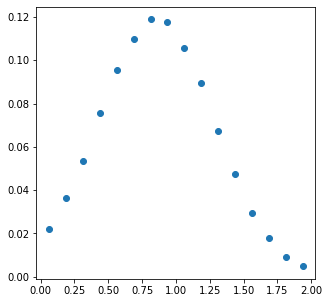

In [227]:
# Alternatively (or in addition), plot the AJ distribution for our single point
import matplotlib.pyplot as plt
#example_prediction = predict_xj(0.3, 0.3, 0, 0.3)
#example_prediction = predict_xjgamma_smeared(0.2, 0.6, 0.2, 0.3)
example_prediction = predict_xjgamma_smeared_fix(0.05, 0.3, -0.1, 0.3)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(np.arange(DataXMin, DataXMax, DataXBin) + (DataXBin / 2), example_prediction, marker="o", linestyle="")

In [20]:
# Test

In [19]:
!pip install ipywidgets

In [8]:
%pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.1/508.1 kB 4.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
_x = np.arange(DataXMin, DataXMax, DataXBin) + (DataXBin / 2)

Running xj prediction with 0.1, 0.3, 1, 0.3


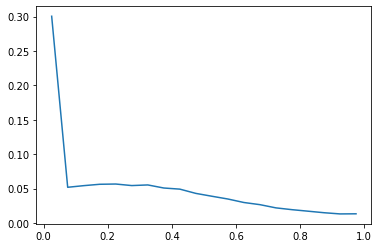

interactive(children=(FloatSlider(value=1.0, description='A', max=1.0), FloatSlider(value=0.0, description='B'…

<function __main__.update(A=1, B=0, C=0)>

In [9]:
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(_x, predict_xj(A=0.1, B=0.3, C=1, D=0.3))

def update(A = 1, B = 0, C = 0):
    line.set_ydata(f(x,A,B,C))
    fig.canvas.draw_idle()
    
interact(update, A = (0,1,0.1), B = (0,1,0.1), C = (1,1,0.1), D = (1,1,0.1))

In [74]:
from typing import Union
import numpy.typing as npt
_x = np.linspace(0, 2, 20)

def gaussian(
    x: Union[npt.NDArray[np.float64], float], mean: float, sigma: float
) -> Union[npt.NDArray[np.float64], float]:
     r"""Normalized gaussian.

     .. math::

         f = 1 / \sqrt{2 * \pi * \sigma^{2}} * \exp{-\frac{(x - \mu)^{2}}{(2 * \sigma^{2}}}

     Args:
         x: Value(s) where the gaussian should be evaluated.
         mean: Mean of the gaussian distribution.
         sigma: Width of the gaussian distribution.
     Returns:
         Calculated gaussian value(s).
     """
     return 1.0 / np.sqrt(2 * np.pi * np.square(sigma)) * np.exp(-1.0 / 2.0 * np.square((x - mean) / sigma))  # type: ignore

def extended_gaussian(
    x: Union[npt.NDArray[np.float64], float], mean: float, sigma: float, amplitude: float
) -> Union[npt.NDArray[np.float64], float]:
    r"""Extended gaussian.

    .. math::

        f = A / \sqrt{2 * \pi * \sigma^{2}} * \exp{-\frac{(x - \mu)^{2}}{(2 * \sigma^{2}}}

    Args:
        x: Value(s) where the gaussian should be evaluated.
        mean: Mean of the gaussian distribution.
        sigma: Width of the gaussian distribution.
        amplitude: Amplitude of the gaussian.
    Returns:
        Calculated gaussian value(s).
    """
    return amplitude / np.sqrt(2 * np.pi * np.square(sigma)) * np.exp(-1.0 / 2.0 * np.square((x - mean) / sigma))  # type: ignore

def test_func(x: npt.NDArray[np.float64], a: float, b: float, c: float, d: float, e: float) -> float:
    return e*(1-gaussian(x, a, b)) - gaussian(x, c, d)

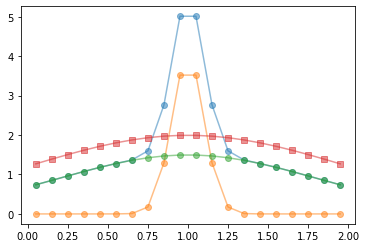

In [83]:
_x = np.arange(DataXMin, DataXMax, DataXBin) + (DataXBin / 2)
fig, ax = plt.subplots()
ax.plot(_x, extended_gaussian(_x, 1, 0.1, 1) + extended_gaussian(_x, 1, 0.8, 3), marker="o", alpha=0.5)
ax.plot(_x, extended_gaussian(_x, 1, 0.1, 1), marker="o", alpha=0.5)
ax.plot(_x, extended_gaussian(_x, 1, 0.8, 3), marker="o", alpha=0.5)
#ax.plot(_x, extended_gaussian(_x, 1, 1, 5), marker="o", alpha=0.5)
ax.plot(_x, 5*gaussian(_x, 1, 1), marker="s", alpha=0.5)

## Making the design points

Let's start with a very simple random array :D

In reality we would use something more complicated to distribute the points better, but let's start simple.  Fancy stuff is just a better way to achieve the same purpose.

In [278]:
#Design = np.random.rand(NDesign, 3) * ParameterRanges
design = np.array([
    np.random.uniform(low=p[0], high=p[1], size=NDesign)
    for p in ParameterRanges
]).T

In [269]:
design[:, 0].tolist()

[0.8418076768382686,
 0.6675401283237032,
 0.35585796422338656,
 0.26206165468690934,
 0.7490293340728149,
 0.1813195814092926,
 0.9439442203653641,
 0.2528063816210909,
 0.11203354249697262,
 0.17123836211860055,
 0.18814163616438828,
 0.22747208699084465,
 0.1749882261739455,
 0.844959455241212,
 0.5243801405673154,
 0.583568958473568,
 0.40703756710050043,
 0.7242440406856373,
 0.4630807739117485,
 0.5357903145624118,
 0.20544222648647592,
 0.7933854127380611,
 0.71171157431941,
 0.4301975233729217,
 0.9091373857207646,
 0.565559571087707,
 0.8238777532266158,
 0.9306740891138262,
 0.532034337675418,
 0.7473996858981004,
 0.1820456689931098,
 0.9191858762472903,
 0.20995309191176015,
 0.7493472666156697,
 0.410702938733025,
 0.17031310192335725,
 0.6612560557793011,
 0.65407508415022,
 0.7176427524766039,
 0.5808378979905828,
 0.5344734817491408,
 0.1260309747290559,
 0.4336633345755164,
 0.9107891074781718,
 0.2316557401987921,
 0.29087856049017735,
 0.14741280110290278,
 0.6014534

In [112]:
def f(x, y):
    return x + y

my_x = np.random.rand(10)
my_y = np.random.rand(10)
np.allclose(f(my_x, my_y), my_x + my_y)

True

In [189]:
Y1 = np.array([
    #np.vectorize(predict_xjgamma_smeared_fix)(A=design[0, :], B=design[1, :], C=design[2, :], D=design[3, :]) for d in design
    predict_xjgamma_smeared_fix(A=d[0], B=d[1], C=d[2], D=d[3]) for d in design.T
])

Running xj_gamma smeared prediction with 0.8738962830511595, 0.22552394537576326, 1.3309290665636784, 0.16876124901680922
Running xj_gamma smeared prediction with 0.23455061024535961, 0.7321936221638388, 1.9554885747352362, 0.5707665599111862
Running xj_gamma smeared prediction with 0.38600208435586614, 0.35407247928133634, 0.9789516483111371, 0.5806717030769735
Running xj_gamma smeared prediction with 0.6157171038353664, 0.7080809479119221, 0.17616464498289686, 0.45505605419301
Running xj_gamma smeared prediction with 0.6459869471336911, 0.6622992489880575, 1.5940636362653149, 0.7863611129096495
Running xj_gamma smeared prediction with 0.5693736776322035, 0.9303509396164098, 0.38685851494283496, 0.9113680409097555
Running xj_gamma smeared prediction with 0.6628513850892666, 0.29593943240539244, -0.824471764747082, 0.4022407870518928
Running xj_gamma smeared prediction with 0.12598401440212859, 0.8181927236098873, -0.22644604201197793, 0.7174009621200287
Running xj_gamma smeared predic

In [190]:
Y1[0]

array([0.00000000e+00, 2.05535059e-05, 1.02767530e-05, 4.11070118e-05,
       2.05535059e-04, 7.60479719e-04, 2.44586720e-03, 6.83404072e-03,
       1.49218453e-02, 2.83021776e-02, 5.22161818e-02, 8.00147985e-02,
       1.10444264e-01, 1.36423896e-01, 1.44378102e-01, 1.36465003e-01,
       1.13054559e-01, 8.48859794e-02, 5.68098903e-02, 3.17654434e-02])

In [270]:
predict_xjgamma_smeared_fix(A=design[-1, 0], B=design[-1, 1], C=design[-1, 2], D=design[-1, 3])

Running xj_gamma smeared prediction with 0.2993069727523022, 0.28584026000298, 0.7389127546530276, 0.36174604754038964


array([0.0012632 , 0.00276324, 0.00624831, 0.01167328, 0.01980511,
       0.03312506, 0.04877966, 0.06738924, 0.08597627, 0.10511594,
       0.11824416, 0.12082694, 0.11897726, 0.1044054 , 0.08661915,
       0.06878778])

## Preparing the model predictions

Let's loop over the design points, and call the predict function we just wrote to make a big table!

This step takes a while, like a few minutes.  Please be patient.

In [279]:
# Generate prediction for "central" data
#Y1 = [predict_xjgamma_smeared(i[0], i[1], i[2]) for i in design]
Y1 = np.array([
    predict_xjgamma_smeared_fix(A=d[0], B=d[1], C=d[2], D=d[3]) for d in design
])
# Generate prediction for "peripheral" data.  Note here A and B are irrelevant.  So we set them to 0
#Y2 = [predict_xjgamma_smeared(0, 0, i[2]) for i in design]
Y2 = np.array([
    # A = 1 so that the XJ cancels out to 0, and then it's just the second term that dominates
    predict_xjgamma_smeared_fix(A=1, B=0, C=d[2], D=d[3]) for d in design
])

Running xj_gamma smeared prediction with 0.37359778368993635, 0.8930993572564337, 0.7132575511504808, 0.8448114395492224
Running xj_gamma smeared prediction with 0.749400028572315, 0.0006269062900189359, 0.6018643818586611, 0.7416165787071818
Running xj_gamma smeared prediction with 0.795123851871947, 0.09760763324300548, 0.9160296723574891, 0.5798558394314414
Running xj_gamma smeared prediction with 0.7461174399845691, 0.7178097640772001, 1.1443592751329608, 0.297217935896983
Running xj_gamma smeared prediction with 0.9809181830228657, 0.7001541655728573, 1.4709692114800377, 0.21570629951189652
Running xj_gamma smeared prediction with 0.46077934448615576, 0.09380414520703362, 0.6826875863994895, 0.22783082354618717
Running xj_gamma smeared prediction with 0.5056464424225896, 0.20665204633632706, 0.6166403111234023, 0.4961654171431369
Running xj_gamma smeared prediction with 0.05769909246664473, 0.6973329995736378, 0.9664841313008198, 0.26716845946293544
Running xj_gamma smeared predic

In [259]:
Y2 = np.array([
    # A = 1 so that the XJ cancels out to 0, and then it's just the second term that dominates
    predict_xjgamma_smeared_fix(A=1, B=0, C=d[2], D=d[3]) for d in design.T[32:33]
])
#Y2

Running xj_gamma smeared prediction with 1, 0, -0.21077368132427554, 0.027992744735200192


/var/folders/s4/zc_9tsr13mvbdxfpt284svpm0000gp/T/ipykernel_21164/407641116.py:51: RuntimeWarning: invalid value encountered in true_divide
  return h / h.sum()


## Write everything out

In [280]:
with open(folder / 'Prediction_Selection1.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write('# Data Data_Selection1.dat\n')
    f.write('# Design Design.dat\n')
    np.savetxt(f, np.transpose(Y1))

In [281]:
with open(folder / 'Prediction_Selection2.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write('# Data Data_Selection2.dat\n')
    f.write('# Design Design.dat\n')
    np.savetxt(f, np.transpose(Y2))

In [282]:
with open(folder / 'Design.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write(f'# Parameter {" ".join("A B C D E F G H I J K L".split()[:design.shape[1]])}\n')
    np.savetxt(f, design)

## Making fake data

In [11]:
Truth = [0.50, 0.25, 0.10]

DataY1 = Predict(Truth[0], Truth[1], Truth[2], N = 100000)
DataY2 = Predict(0, 0, Truth[2], N = 100000)

Running prediction with 0.5 0.25 0.1
Running prediction with 0 0 0.1


In [12]:
XMin = np.array(range(0, DataNBin)) * DataXBin
XMax = np.array(range(1, DataNBin + 1)) * DataXBin

Stat = 0.001
Sys = 0.010

Data1 = np.zeros((DataNBin, 7))
Data2 = np.zeros((DataNBin, 7))

Data1[:,0] = XMin
Data1[:,1] = XMax
Data1[:,2] = DataY1
Data1[:,3] = Stat
Data1[:,4] = Stat
Data1[:,5] = Sys
Data1[:,6] = Sys

Data2[:,0] = XMin
Data2[:,1] = XMax
Data2[:,2] = DataY2
Data2[:,3] = Stat
Data2[:,4] = Stat
Data2[:,5] = Sys
Data2[:,6] = Sys

In [13]:
with open(Folder + 'Data_Selection1.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write('# DOI None\n')
    f.write('# Source None\n')
    f.write('# Experiment JetScape\n')
    f.write('# System PbPb5020\n')
    f.write('# Centrality 0to10\n')
    f.write('# XY AJ DNDAJ\n')
    f.write('# Label xmin xmax y stat,low stat,high sys,low sys,high\n')
    np.savetxt(f, Data1)
    
with open(Folder + 'Data_Selection2.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write('# DOI None\n')
    f.write('# Source None\n')
    f.write('# Experiment JetScape\n')
    f.write('# System PbPb5020\n')
    f.write('# Centrality 70to90\n')
    f.write('# XY AJ DNDAJ\n')
    f.write('# Label xmin xmax y stat,low stat,high sys,low sys,high\n')
    np.savetxt(f, Data2)